### Tool using `GPT`

In [1]:
import json,openai,sys
import numpy as np
import matplotlib.pyplot as plt
from gpt_helper import DataLogClass,MavenClass
from openai import OpenAI
from util import optimization_based_smoothing_1d
np.set_printoptions(precision=2)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print("openai version:[%s]" % (openai.__version__))

openai version:[1.13.3]


#### Define custom `API`s and descriptions (aka `tools`)

In [2]:
def api_plot(data,figsize=(4,2)):
    """ 
        Plot trajectory
    """
    
    plt.figure(figsize=figsize)
    for d_idx in range(data.d):
        plt.plot(data.t,data.x[:,d_idx],'-')
    plt.show()
    # Out
    out = json.dumps({"figsize":figsize,"status":"success"})
    return out
    
def api_smooth(data,max_vel=None):
    """ 
        Smooth multi-dimensional trajectory
    """
    for d_idx in range(data.d): # for each dimension
        data.x[d_idx] = optimization_based_smoothing_1d(
            traj      = data.x[d_idx],
            dt        = data.dt,
            vel_limit = max_vel,
        )
    # Out
    out = json.dumps({"status":"success"})
    return out

def api_affine_transform(data,A,b):
    """ 
        Affine transform
        :param A: ndarray [d x d]
        :param b: ndarray [d x 1]
    """
    if isinstance(A,list): A = np.array(A)
    if isinstance(b,list): b = np.array(b)    
    data.x = (A@data.x.T + b).T
    # Out
    out = json.dumps({"status":"success"})
    return out

tools = [
    {
        "type": "function",
        "function": {
            "name": "plot",
            "description": "Plot the current trajectory.",
            "parameters": {},
        },
    },
    {
        "type": "function",
        "function": {
            "name": "smooth",
            "description": "Smooth the current trajectory.",
            "parameters": {},
        },
    },
    {
        "type": "function",
        "function": {
            "name": "affine_transform",
            "description": "Affine transform the current trajectory.",
            "parameters": {},
        },
    },
]

function_mappings = {
    "plot": api_plot,
    "smooth": api_smooth,
    "affine_transform": api_affine_transform,
}

print ("Ready.")

Ready.


#### Run

In [3]:
# Instantiate OpenAI client
key_path = "../key/rilab_key.txt"
with open(key_path, "r") as f:
    OPENAI_API_KEY = f.read()
client = OpenAI(api_key=OPENAI_API_KEY)

# Initialize the initial trajectories and data log 
t = np.linspace(start=0.0,stop=1.0,num=100) # [L]
x = np.vstack((np.sin(2*np.pi*t),np.cos(2*np.pi*t))).T # [L x D]
system_prompt = """
    You are given motion data (t, x) where t is the time and x is the position.
    # motion data shape
    t : numpy ndarray of shape [L]
    x : numpy ndarray of shape [L x d] where d is 2.
    # Followings are some examples you should consider:
    When plotting a figure, the input argument is 'figsize' of type tuple (e.g., (5,2)).
    The 'figsize' of (6,3) is big and 'figsize' of (4,2) is small. 
    'affine_transform' function is to transform the motion using two parameters 'A' and 'b'.
    'A' is an array of size [d x d] and 'b' is an array of size [d x 1].
    For example, when we want to maintain the scale 'A' shoud be [[1,0],[0,1]] and 'b' should be [[0],[0]].
    If we wand to scale it double, 'A' should be np.array([[2,0],[0,2]]) and 'b' should be [[0],[0]].
"""
datalog = DataLogClass(t=t,x=x,system_prompt=system_prompt)

# Instantiate Maven
maven = MavenClass(
    client            = client,
    datalog           = datalog,
    tools             = tools,
    function_mappings = function_mappings,
    model             = 'gpt-4o', #'gpt-4-1106-preview',
)

print ("Ready.")

Ready.


#### Plot the original trajectories

In [4]:
maven.recommend_api(usr_msg = "Plot in a middle-sized figure.",n_choice=3,verbose=True)

choice:[0/3] tool_idx:[0/1] function_name:[plot] function_args:{}

choice:[1/3] tool_idx:[0/2] function_name:[plot] function_args:{}
choice:[1/3] tool_idx:[1/2] function_name:[plot] function_args:{"figsize": [5, 2]}

choice:[2/3] tool_idx:[0/1] function_name:[plot] function_args:{}


choice_idx:[0] selected
tool_idx:[0/1] function_name:[plot] function_args:{}


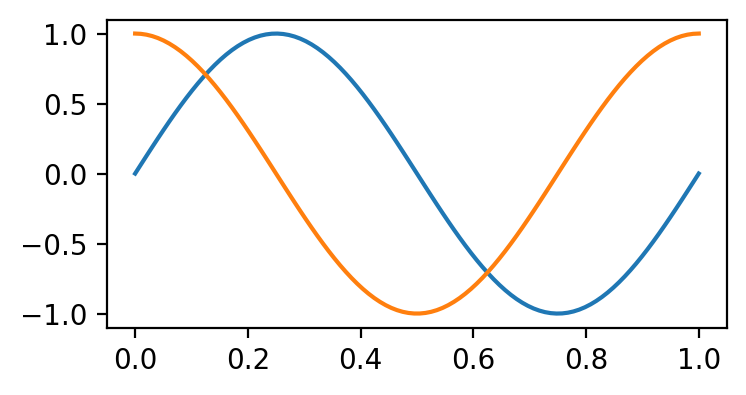

In [5]:
maven.select_recommended_api(choice_idx=0,verbose=True)

#### Scale and plot

In [6]:
maven.recommend_api(
    usr_msg = 
    """
        Scale the motion into half and plot it in a small-sized figure.
    """,
    n_choice = 3,
    verbose  = True,
)

choice:[0/3] tool_idx:[0/2] function_name:[affine_transform] function_args:{"A": [[0.5, 0], [0, 0.5]], "b": [[0], [0]]}
choice:[0/3] tool_idx:[1/2] function_name:[plot] function_args:{"figsize": [4, 2]}

choice:[1/3] tool_idx:[0/2] function_name:[affine_transform] function_args:{"A": [[0.5, 0], [0, 0.5]], "b": [[0], [0]]}
choice:[1/3] tool_idx:[1/2] function_name:[plot] function_args:{"figsize": [4, 2]}

choice:[2/3] tool_idx:[0/2] function_name:[affine_transform] function_args:{"A": [[0.5, 0], [0, 0.5]], "b": [[0], [0]]}
choice:[2/3] tool_idx:[1/2] function_name:[plot] function_args:{"figsize": [4, 2]}


choice_idx:[1] selected
tool_idx:[0/2] function_name:[affine_transform] function_args:{"A": [[0.5, 0], [0, 0.5]], "b": [[0], [0]]}
tool_idx:[1/2] function_name:[plot] function_args:{"figsize": [4, 2]}


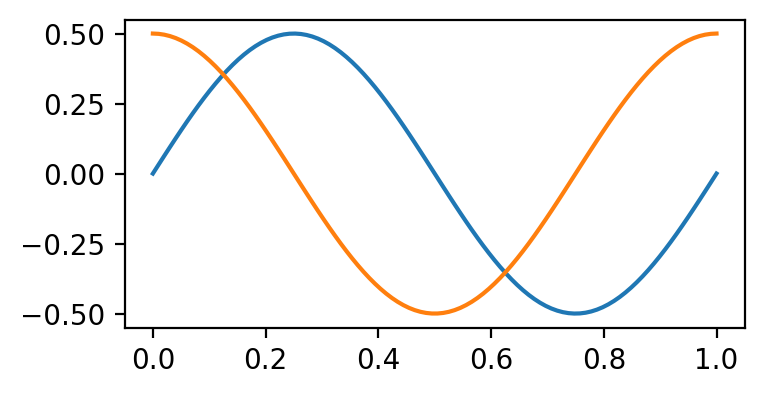

In [7]:
maven.select_recommended_api(choice_idx=1,verbose=True)